# Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Data loading and preperation

In [3]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(),
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])

In [4]:
test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [5]:
root = 'Flower/'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transform)
#we can just cast train root completely in imagefolder() paranthesis
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)


train_loader = DataLoader(train_data,batch_size=100,shuffle=True)
test_loader = DataLoader(test_data,batch_size=100,shuffle=False)

class_names = train_data.classes # specify classes

In [6]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
len(train_data)

3915

In [8]:
len(test_data)

408

# Data visualization

In [9]:
for i,(images,labels) in enumerate(train_loader):
    break

In [10]:
images.shape

torch.Size([100, 3, 224, 224])

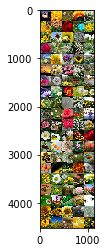

In [11]:
im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

# Convolutional Neural Network

In [12]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.conv3 = nn.Conv2d(16,32,3,1)
        self.fc1 = nn.Linear(26*26*32,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,7)
        
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,26*26*32)
        X = F.relu(self.fc1(X))
        X = F.dropout(X)
        X = F.relu(self.fc2(X))
        X = F.dropout(X)
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [13]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [14]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

# Parameter check

In [15]:
for param in model.parameters():
    print(param.numel())

162
6
864
16
4608
32
2595840
120
10080
84
588
7


# Training

In [16]:
import time
start_time = time.time()

epochs = 30


train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy = []
accuracy_test = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        
       
        b = b + 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr = trn_corr + batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print('Epoch:  {} Loss:  {} Accuracy:  {}'.format(i,loss,trn_corr.item()*100/(100*b)))
    accuracy.append((trn_corr.item()*100/(b*100)))
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    #test set
    
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            b = b + 1
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr
            accuracy_test.append(tst_corr.item()*100/(50*b))
    
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
    
total_time = time.time() - start_time
print(f'Total Time: {total_time/60}) minutes')

Total Time: 55.45936376253764) minutes


# Result

In [17]:
100*trn_corr.item()/len(train_data)

57.01149425287356

In [18]:
100*tst_corr.item()/len(test_data)

58.088235294117645

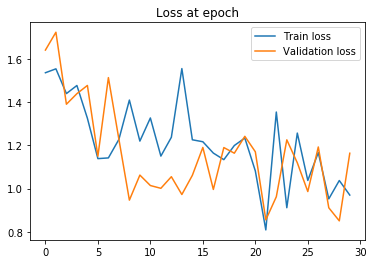

In [19]:
plt.plot(train_losses,label='Train loss')
plt.plot(test_losses,label='Validation loss')
plt.title('Loss at epoch')
plt.legend()
plt.show()

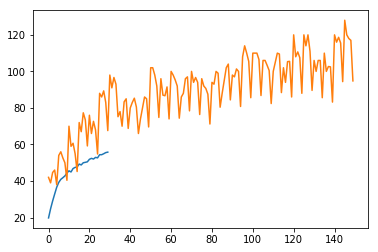

In [22]:
plt.plot(range(30),accuracy)
plt.plot(range(150),accuracy_test)

In [ ]:
model.eval()

with torch.no_grad():
    tst_corr_2 = 0
    for b,(X_test,y_test) in enumerate(test_loader):
           
                        
        y_val = model(X_test)
        predicted = torch.max(y_val.data,1)[1]
        batch_corr = (predicted == y_test).sum()
        tst_corr = batch_corr + tst_corr
        
        
    
    


In [26]:
len(test_data)

408

In [ ]:
train_correct

# Confusion Matrix

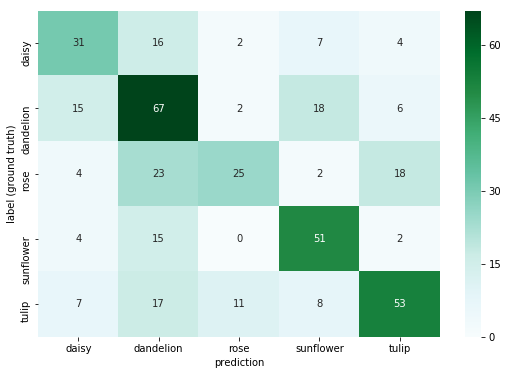

In [27]:

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=408, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();